In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
cam = cv2.VideoCapture(0)
face_cas = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

f_01 = np.load('face_01.npy').reshape((20, 50*50*3))	# Akul
f_02 = np.load('face_02.npy').reshape((20, 50*50*3))	# Prateek
f_03 = np.load('face_03.npy').reshape((20, 50*50*3))	# Aarnav

print f_01.shape, f_02.shape, f_03.shape

names = {
    0: 'Akul',
    1: 'Prateek', 
    2: 'Aarnav',
}

labels = np.zeros((60, 1))
labels[:20, :] = 0 
labels[20:40, :] = 1
labels[40:, :] = 2

data = np.concatenate([f_01, f_02, f_03])
data = np.array([[labels[ix],data[ix]] for ix in range(data.shape[0])])
print data.shape

(20, 7500) (20, 7500) (20, 7500)
(60, 2)


In [3]:
np.random.shuffle(data)

In [4]:
split = int(0.8*data.shape[0])

x_tr = data[:split,1]/255.0
x_tes = data[split:,1]/255.0

y_tr = np_utils.to_categorical(data[:split, 0])
y_tes = np_utils.to_categorical(data[split:, 0])

print x_tr.shape, x_tes.shape
print y_tr.shape, y_tes.shape

(48,) (12,)
(48, 3) (12, 3)


In [5]:
print x_tr[0].shape

(7500,)


In [6]:
x_tr = np.array([x_tr[ix].reshape((50, 50, 3)) for ix in range(x_tr.shape[0])])
x_tes = np.array([x_tes[ix].reshape((50, 50, 3)) for ix in range(x_tes.shape[0])])

print x_tr.shape, x_tes.shape

(48, 50, 50, 3) (12, 50, 50, 3)


In [7]:
model = Sequential()
model.add(Convolution2D(64,3,3,input_shape=(50,50,3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(16, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(8, 3, 3, activation='relu'))
model.add(Flatten()) #19*19 8
model.add(Dense(100))
model.add(Dropout(0.25))
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(50, 50, 3...)`
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
  import sys
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        18464     
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 16)        4624      
_________________________________________________________________
activation_3 (Activation)    (None, 21, 21, 16)        0         
__________

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model.fit(x_tr, y_tr, batch_size=8, nb_epoch=5, verbose=2,validation_data=(x_tes, y_tes))

/usr/local/lib/python2.7/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 48 samples, validate on 12 samples
Epoch 1/5
 - 2s - loss: 1.1707 - acc: 0.5208 - val_loss: 1.0678 - val_acc: 0.5000
Epoch 2/5
 - 1s - loss: 0.9303 - acc: 0.5625 - val_loss: 0.7212 - val_acc: 0.6667
Epoch 3/5
 - 1s - loss: 0.5402 - acc: 0.8333 - val_loss: 0.1300 - val_acc: 1.0000
Epoch 4/5
 - 1s - loss: 0.1528 - acc: 0.9792 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 5/5
 - 1s - loss: 0.0642 - acc: 0.9792 - val_loss: 4.9746e-04 - val_acc: 1.0000


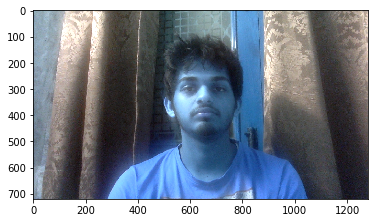

In [10]:
ret, frame = cam.read()

plt.figure(0)
plt.imshow(frame,cmap='gray')
plt.show()

[[ 0.  0.  1.]]
Aarnav


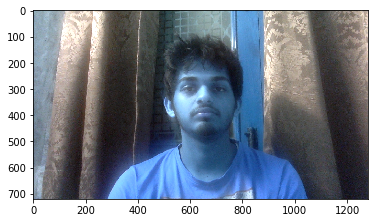

In [11]:
if ret == True :
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_cas.detectMultiScale(gray,1.3,5)
    
    for (x,y,w,h) in faces :
        face_component = frame[y:y+h,x:x+w]
        fc = cv2.resize(face_component,(50,50))
        label = model.predict(np.reshape(fc,(1,50,50,3)))
        print label
        plt.figure(0)
        plt.imshow(frame,cmap='gray')
        print names[np.argmax(label)]
        plt.show()
else:
    print "error"

In [12]:
cv2.destroyAllWindows()
del cam